# Analysis of dataset on titles of new articles
</br></br>
This notebook contains analysis on given dataset. Following are the subsections in this notebook: 
</br>
- Number of unique entries in each column
- Number of articles published in each year
- Authors with maximum number of articles published
- Year wise top 10 articles based on number of up_votes
- Average articles published per year
- Common famous authors across all the years
- Most famous articles
- LDA on titles

In [1]:
import csv
import numpy as np
import pandas as pd
import heapq
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from pprint import pprint
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/hitesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv('Eluvio_DS_Challenge.csv', header=0, index_col=False, delimiter=',')
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


### Number of unique entries in each column

In [3]:
df.nunique()

time_created    508329
date_created      3223
up_votes          5782
down_votes           1
title           500720
over_18              2
author           85838
category             1
dtype: int64

In [4]:
# convert date-time column to 'date-time' datatype of pandas
df['date_created'] = pd.to_datetime(df['date_created'], errors='coerce')

### Number of articles published in each year

In [5]:
# groupby year and month
years = df.groupby(df['date_created'].dt.year)
months = df.groupby(df['date_created'].dt.month)

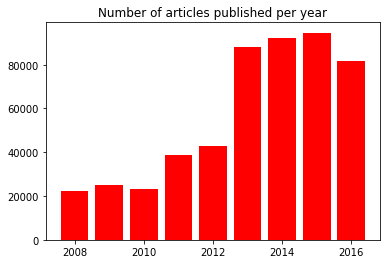

In [6]:
counts = []
for k,v in years.groups.items():
    counts.append((k, len(v)))
years = np.asarray(counts)
plt.bar(years[:,0], years[:,1], align='center', color='red')
plt.title('Number of articles published per year')
plt.show()

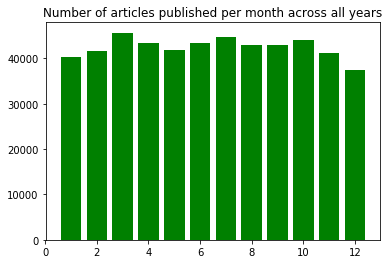

In [7]:
counts = []
for k,v in months.groups.items():
    counts.append((k, len(v)))
counts = np.asarray(counts)
plt.bar(counts[:,0], counts[:,1], align='center', color='green')
plt.title('Number of articles published per month across all years')
plt.show()

### Authors with maximum number of articles published

In [8]:
# group dataset based on author names and count their up_votes
authors = dict(df.groupby('author')['up_votes'].count())
# select top 10 using heap
heap = [(-v,k) for k,v in authors.items()]
largest = heapq.nsmallest(10, heap)
largest = [(k,-v) for v,k in largest]
largest

[('davidreiss666', 8897),
 ('anutensil', 5730),
 ('DoremusJessup', 5037),
 ('maxwellhill', 4023),
 ('igeldard', 4013),
 ('readerseven', 3170),
 ('twolf1', 2923),
 ('madam1', 2658),
 ('nimobo', 2564),
 ('madazzahatter', 2503)]

### Average number of articles published by authors

In [9]:
# groupby author and select the category column just to count total number of rows
work = df.groupby('author')['category'].count()
avg_work  = 0
for k,v in work.items():
    avg_work += v
avg_work /= len(work)
print('Average number of articles for each author =', avg_work)

Average number of articles for each author = 5.932524056944477


### Year wise top 10 articles  based on number of up_votes

In [38]:
# groupby based on two columns viz. 'date_created' and 'author'
y = df.groupby([df['date_created'].dt.year, df['author']])
top_authors = dict((i, []) for i in years[:,0])
yearly_top = []
work_per_year = {i: [0,0] for i in years[:,0]}
count = 0
for k,v in y.groups.items():
    top_authors[k[0]].append((max(v), k[1]))
    work_per_year[k[0]][0] += len(v)
    work_per_year[k[0]][1] += 1
for k,v in top_authors.items():
    heap = heapq.nlargest(10, v)
    print('top 10 authors for the year', k,' (<vote_count, author_name>):\n', heap)
    print('----------------------------------------------------------------')
    heap = np.asarray(heap)
    yearly_top.append(heap[:,1])


top 10 authors for the year 2008  (<vote_count, author_name>):
 [(22504, 'kooby64'), (22503, 'FokkeNews'), (22502, 'kefs'), (22501, 'georgewashingtonblog'), (22500, 'ruppinwedle'), (22499, 'gIowingsheep'), (22498, 'MrDanger'), (22497, 'kcnchfan'), (22496, 'njaard'), (22495, 'ropers')]
----------------------------------------------------------------
top 10 authors for the year 2009  (<vote_count, author_name>):
 [(47619, 'see0red'), (47618, 'HeroOfCanton'), (47617, 'MIIAIIRIIK'), (47616, 'jimmycorpse'), (47615, 'spainguy'), (47614, '00boyina'), (47613, 'SolInvictus'), (47612, 'OrangePlus'), (47611, 'SovereignMan'), (47609, 'purelithium')]
----------------------------------------------------------------
top 10 authors for the year 2010  (<vote_count, author_name>):
 [(70932, 'trot-trot'), (70931, 'galt1776'), (70930, 'transexfever'), (70928, 'jdrucker'), (70927, 'shot_out'), (70926, 'davidreiss666'), (70925, 'bushwarriors'), (70924, 'gavin19'), (70921, 'steppenwolf86'), (70918, 'wrc-wolf

### Average articles published per year

In [40]:
for k,v in work_per_year.items():
    print('Avg. articles published per author in year', k, ':', v[0]/v[1])

Avg. articles published per author in year 2008 : 6.623013537374926
Avg. articles published per author in year 2009 : 4.338400414579374
Avg. articles published per author in year 2010 : 5.16688829787234
Avg. articles published per author in year 2011 : 5.0091459487311605
Avg. articles published per author in year 2012 : 3.956485433290035
Avg. articles published per author in year 2013 : 4.249024801348423
Avg. articles published per author in year 2014 : 5.212097185252308
Avg. articles published per author in year 2015 : 5.154491474641826
Avg. articles published per author in year 2016 : 4.6964500774215745
Average articles published through all the years = 4.783534981588637


### Common famous authors across all the years

In [19]:
def findCommon(mat): 
    M = len(mat)
    N = len(mat[0])
    # An array to store indexes of  
    # current last column 
    column = [N - 1] * M 
  
    min_row = 0 # Initialize min_row as first row 
  
    # Keep finding min_row in current last  
    # column, till either all elements of  
    # last column become same or we hit first column. 
    while (column[min_row] >= 0): 
      
        # Find minimum in current last column 
        for i in range(M): 
            if (mat[i][column[i]] <  
                mat[min_row][column[min_row]]): 
                min_row = i 
      
        # eq_count is count of elements equal  
        # to minimum in current last column. 
        eq_count = 0
  
        # Traverse current last column elements 
        # again to update it 
        for i in range(M): 
              
            # Decrease last column index of a row  
            # whose value is more than minimum. 
            if (mat[i][column[i]] >  
                mat[min_row][column[min_row]]): 
                if (column[i] == 0): 
                    return -1
  
                column[i] -= 1 # Reduce last column 
                               # index by 1 
          
            else: 
                eq_count += 1
  
        # If equal count becomes M, return the value 
        if (eq_count == M): 
            return mat[min_row][column[min_row]] 
    return -1

In [22]:
yearly_top = np.asarray(yearly_top)
# print(yearly_top)
common = findCommon(yearly_top)
print('Common authors across all the years: ', common)
print('Therefore, there is no top author who has highest rating across multiple years')

Common authors across all the years:  -1
Therefore, there is no top author who has highest rating across multiple years


### Most famous articles

In [23]:
avg_up_votes = sum(df['up_votes'])/len(df['up_votes'])
num = 0
for index in df['up_votes']:
    if index > avg_up_votes:
        num += 1
print('Number of articles > avg. up_votes count =', num)

Number of articles > avg. up_votes count = 47902


### Topic Modeling on titles

In [10]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
    '''
    Convert a raw title to a cleaned title
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [11]:
# preprocessing a text
def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english') 
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [12]:
# preprocess the titles and save them in processed_docs
processed_docs = df['title'].map(preprocess)
processed_docs[:10]

0                       [score, kill, pakistan, clash]
1                      [japan, resum, refuel, mission]
2                         [press, egypt, gaza, border]
3                 [jump, start, economi, health, care]
4            [council, europ, bash, terror, blacklist]
5    [presto, farmer, unveil, illeg, mock, tudor, c...
6    [strike, protest, gridlock, poland, ukrain, bo...
7                                  [mismanag, program]
8                 [nicola, sarkozi, threaten, ryanair]
9    [plan, missil, shield, polish, town, resist, v...
Name: title, dtype: object

In [13]:
# Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 clash
1 kill
2 pakistan
3 score
4 japan
5 mission
6 refuel
7 resum
8 border
9 egypt
10 gaza


Filter out tokens that appear in </br>
- less than 15 documents (absolute number) or
- more than 0.5 documents (fraction of total corpus size, not absolute number).
- after the above two steps, keep only the first 100000 most frequent tokens.

In [14]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’

In [15]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [16]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [17]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

For each topic, we will explore the words occuring in that topic and its relative weight

In [55]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.025*"world" + 0.016*"warn" + 0.015*"say" + 0.014*"china" + 0.011*"global" + 0.009*"news" + 0.009*"scientist" + 0.008*"russia" + 0.008*"report" + 0.008*"studi"
Topic: 1 
Words: 0.021*"death" + 0.017*"court" + 0.016*"year" + 0.016*"right" + 0.015*"human" + 0.015*"saudi" + 0.012*"women" + 0.012*"charg" + 0.011*"case" + 0.010*"arabia"
Topic: 2 
Words: 0.031*"protest" + 0.030*"polic" + 0.014*"thousand" + 0.011*"migrant" + 0.010*"london" + 0.010*"citi" + 0.009*"news" + 0.009*"video" + 0.009*"trump" + 0.007*"home"
Topic: 3 
Words: 0.029*"refuge" + 0.026*"israel" + 0.023*"bank" + 0.019*"palestinian" + 0.019*"isra" + 0.017*"deal" + 0.013*"peac" + 0.011*"west" + 0.010*"ship" + 0.010*"flight"
Topic: 4 
Words: 0.016*"vote" + 0.013*"germani" + 0.012*"european" + 0.011*"billion" + 0.010*"million" + 0.010*"elect" + 0.009*"year" + 0.008*"migrant" + 0.008*"compani" + 0.007*"say"
Topic: 5 
Words: 0.032*"state" + 0.031*"isi" + 0.027*"syria" + 0.025*"say" + 0.023*"minist" + 0.021*"iran"

Running LDA using TF-IDF

In [56]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.012*"brexit" + 0.010*"vote" + 0.009*"elect" + 0.009*"minist" + 0.008*"presid" + 0.007*"parti" + 0.006*"parliament" + 0.005*"referendum" + 0.005*"prime" + 0.005*"say"
Topic: 1 Word: 0.006*"kurd" + 0.005*"brussel" + 0.005*"jet" + 0.005*"panama" + 0.004*"space" + 0.004*"jong" + 0.004*"zealand" + 0.004*"attack" + 0.004*"kenya" + 0.004*"kill"
Topic: 2 Word: 0.006*"china" + 0.005*"billion" + 0.005*"say" + 0.005*"taiwan" + 0.004*"bank" + 0.004*"russia" + 0.004*"greek" + 0.004*"year" + 0.004*"record" + 0.004*"deal"
Topic: 3 Word: 0.016*"isi" + 0.011*"attack" + 0.011*"islam" + 0.009*"state" + 0.009*"pari" + 0.007*"terror" + 0.007*"arrest" + 0.007*"kill" + 0.006*"suspect" + 0.006*"syria"
Topic: 4 Word: 0.009*"china" + 0.008*"climat" + 0.007*"world" + 0.006*"global" + 0.006*"greec" + 0.006*"chang" + 0.005*"year" + 0.005*"say" + 0.005*"india" + 0.004*"energi"
Topic: 5 Word: 0.008*"china" + 0.007*"pope" + 0.005*"ship" + 0.005*"boat" + 0.005*"trump" + 0.005*"navi" + 0.005*"malaysia"

Check where our test document i.e. datapoint at index 0 would be classified

In [57]:
for index, score in sorted(lda_model[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))



Score: 0.4484669864177704	 
Topic: 0.020*"presid" + 0.018*"brexit" + 0.017*"pari" + 0.016*"leader" + 0.012*"french" + 0.012*"climat" + 0.012*"german" + 0.012*"rule" + 0.012*"parti" + 0.011*"say"

Score: 0.437173992395401	 
Topic: 0.021*"death" + 0.017*"court" + 0.016*"year" + 0.016*"right" + 0.015*"human" + 0.015*"saudi" + 0.012*"women" + 0.012*"charg" + 0.011*"case" + 0.010*"arabia"

Score: 0.014297930523753166	 
Topic: 0.032*"state" + 0.031*"isi" + 0.027*"syria" + 0.025*"say" + 0.023*"minist" + 0.021*"iran" + 0.020*"islam" + 0.019*"turkey" + 0.011*"forc" + 0.011*"iraq"

Score: 0.01429768931120634	 
Topic: 0.059*"kill" + 0.044*"attack" + 0.025*"russian" + 0.022*"syrian" + 0.020*"dead" + 0.020*"bomb" + 0.017*"pakistan" + 0.013*"polic" + 0.013*"suspect" + 0.011*"aleppo"

Score: 0.014295076951384544	 
Topic: 0.031*"protest" + 0.030*"polic" + 0.014*"thousand" + 0.011*"migrant" + 0.010*"london" + 0.010*"citi" + 0.009*"news" + 0.009*"video" + 0.009*"trump" + 0.007*"home"

Score: 0.01429431